# IMPORT LIBS

In [ ]:
import sys
sys.path.insert(1, "/home/lucas/AffectiveComputing")

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from libs.pre_processing import PreProcessing 
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer
from warnings import filterwarnings
import tensorflow as tf
from os import environ
import pandas as pd
import numpy as np


model_name = 'neuralmind/bert-base-portuguese-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

pp = PreProcessing()
filterwarnings("ignore")

# EXEMPLO NO ARTIGO: CARROS E MOTOS

In [18]:
np.random.seed(42)
data = pd.DataFrame({
    'Velocidade': np.random.uniform(0, 100, 100),
    'Peso': np.random.uniform(500, 2000, 100),
    'Cilindrada': np.random.randint(500, 2000, 100),
    'Quantidade_Rodas': np.random.choice([2, 4], size=100),  # Adicionando a nova coluna
    'Tipo': np.random.choice(['carro', 'moto'], size=100)
})

data.loc[data['Tipo'] == 'moto', 'Quantidade_Rodas'] = 2
data.loc[data['Tipo'] == 'carro', 'Quantidade_Rodas'] = 4


train_data, test_data, train_labels, test_labels = train_test_split(
    data[['Velocidade', 'Peso', 'Cilindrada', 'Quantidade_Rodas']],
    data['Tipo'],
    test_size=0.2,
    random_state=42
)

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(train_data, train_labels)

predictions = rf_classifier.predict(test_data)

accuracy = accuracy_score(test_labels, predictions)
print(f'Acurácia do RandomForestClassifier: {accuracy}')


Acurácia do RandomForestClassifier: 1.0


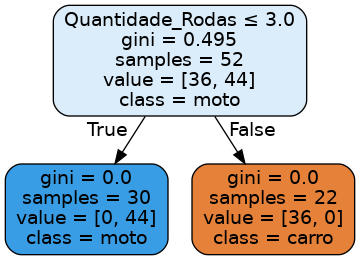

In [20]:
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus

tree = rf_classifier.estimators_[0]

dot_data = export_graphviz(tree, out_file=None, 
                           feature_names=train_data.columns,
                           class_names=data['Tipo'].unique(),
                           filled=True, rounded=True, special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data)  

graph.write_png('arvore_decisao.png')

Image(graph.create_png())


# LOAD DATA

In [22]:
path = '/home/lucas/AffectiveComputing/data_source/ceweb/test.csv'
data = pd.read_csv(path, delimiter='\t')

In [23]:
emotion_name = {0: 'admiração', 1: 'diversão', 2: 'raiva', 3: 'aborrecimento',
                4: 'provação', 5: 'confusão', 6: 'curiosidade', 7: 'desejo',
                8: 'decepção', 9: 'desaprovação', 10: 'nojo', 11: 'vergonha', 
                12: 'entusiasmo', 13: 'medo', 14: 'gratidão', 15: 'luto', 
                16: 'alegria', 17: 'amor', 18: 'nervosismo', 19: 'otimismo',
                20: 'orgulho', 21: 'alívio', 22: 'remorso', 23: 'tristeza',  
                24: 'surpresa', 25: 'saudade', 26: 'inveja', 27: 'compaixão'}
emotion_name

{0: 'admiração',
 1: 'diversão',
 2: 'raiva',
 3: 'aborrecimento',
 4: 'provação',
 5: 'confusão',
 6: 'curiosidade',
 7: 'desejo',
 8: 'decepção',
 9: 'desaprovação',
 10: 'nojo',
 11: 'vergonha',
 12: 'entusiasmo',
 13: 'medo',
 14: 'gratidão',
 15: 'luto',
 16: 'alegria',
 17: 'amor',
 18: 'nervosismo',
 19: 'otimismo',
 20: 'orgulho',
 21: 'alívio',
 22: 'remorso',
 23: 'tristeza',
 24: 'surpresa',
 25: 'saudade',
 26: 'inveja',
 27: 'compaixão'}

In [25]:
def _preprocessing_train(dataframe, column):
    dataframe = pp.dropnan_and_lowercase(dataframe, column)
    dataframe = pp.change_abbreviations_dataframe(dataframe, column)
    dataframe = pp.drop_size(dataframe, column, 3)
    dataframe = pp.set_category(dataframe, 'categoria')
    dataframe = pp.apply_regex_dataframe(dataframe, column)
    dataframe = pp.shuffled_dataframe(dataframe)
    dataframe = pp.remove_stopwords_dataframe(dataframe, column)
    return dataframe

In [26]:
data = _preprocessing_train(data, "tweet")
texts = data.tweet
labels = np.array(data.categoria.tolist())

texts_train, texts_val, labels_train, labels_val = train_test_split(texts, labels, test_size=0.2, random_state=42)

texts_train = texts_train.tolist()

inputs_train = tokenizer(texts_train, max_length=64, padding=True, truncation=True, return_tensors='tf')

labels_train = tf.convert_to_tensor(labels_train, dtype=tf.int64)

inputs_train_ids = inputs_train['input_ids']
inputs_train_ids = np.array(inputs_train_ids).astype(int)

labels_train_np = labels_train.numpy()

texts_val = texts_val.tolist()
inputs_val = tokenizer(texts_val, max_length=64, padding=True, truncation=True, return_tensors='tf')
inputs_val_ids = np.array(inputs_val['input_ids']).astype(int)

2023-12-27 19:35:28.241989: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-27 19:35:28.242556: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# RANDOM FOREST

In [41]:
total_samples = len(labels_train_np)
class_counts = np.bincount(labels_train_np)
class_weights = {cls: total_samples / count for cls, count in enumerate(class_counts)}


param_grid = {
    'n_estimators': [100, 250, 500],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', class_weights]
}

rf_classifier = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')

grid_search.fit(inputs_train_ids, labels_train_np)

best_params = grid_search.best_params_
best_rf_classifier = grid_search.best_estimator_

predictions = best_rf_classifier.predict(inputs_val_ids)

accuracy = accuracy_score(labels_val, predictions)
print(f'Melhores valores para os hiperparâmetros: {best_params}')
print(f'Acurácia com o melhor modelo: {accuracy}')

Melhores valores para os hiperparâmetros: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'n_estimators': 500}
Acurácia com o melhor modelo: 0.21271491403438625


In [42]:
labels_val_names = [emotion_name[label] for label in labels_val]
pred_labels_names = [emotion_name[label] for label in predictions]
report = classification_report(labels_val_names, pred_labels_names)

print(report)

               precision    recall  f1-score   support

aborrecimento       0.50      0.07      0.12        57
    admiração       0.25      0.13      0.17       129
      alegria       0.19      0.06      0.09       111
       alívio       0.56      0.08      0.15        59
         amor       0.44      0.14      0.21        79
    compaixão       0.00      0.00      0.00        49
     confusão       0.17      0.75      0.28       279
  curiosidade       0.25      0.05      0.08        61
     decepção       0.25      0.07      0.11        42
 desaprovação       0.25      0.03      0.06        32
       desejo       0.18      0.25      0.21       200
     diversão       0.11      0.16      0.13       203
   entusiasmo       0.26      0.08      0.13       120
     gratidão       0.00      0.00      0.00         5
       inveja       0.37      0.10      0.16        70
         luto       0.31      0.06      0.09        72
         medo       0.34      0.31      0.33       115
   nervos